In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data
data = Path('Resource/sampled_rideshare_ver2.csv')
df = pd.read_csv(data)
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,day_of_week,is_weekend
0,ad4dc1c8-74e4-4018-aefe-be4e4b8e1ee5,1969-12-31 19:00:01.545085210-05:00,22,17,12,2018-12-17 22:20:10,America/New_York,northeastern university,theatre district,uber,...,34.25,1545044400,41.35,1545076800,28.40,1545044400,35.88,1545076800,1,False
1,47547461-f88b-4c14-9920-1d4a79e7025f,1969-12-31 19:00:01.543366102-05:00,0,28,11,2018-11-28 00:48:22,America/New_York,northeastern university,theatre district,lyft,...,36.13,1543377600,46.83,1543320000,32.05,1543377600,43.85,1543320000,3,False
2,45fba16d-75f1-4e10-bbb7-614f7f1624ae,1969-12-31 19:00:01.543701476-05:00,21,1,12,2018-12-01 21:57:56,America/New_York,beacon hill,north end,uber,...,30.17,1543662000,44.11,1543690800,25.87,1543662000,43.44,1543690800,6,True
3,79ff5573-1bd4-406d-91c3-5e9b2b60d2b2,1969-12-31 19:00:01.544793612-05:00,13,14,12,2018-12-14 13:20:11,America/New_York,haymarket square,beacon hill,uber,...,27.18,1544781600,46.65,1544814000,24.51,1544785200,43.86,1544817600,5,False
4,80e33aa2-c291-41f0-b88d-adb3616bf154,1969-12-31 19:00:01.544851211-05:00,5,15,12,2018-12-15 05:20:11,America/New_York,north end,west end,lyft,...,39.54,1544929200,54.47,1544896800,36.46,1544929200,53.80,1544896800,6,True


In [3]:
# Pivot data to compare Uber and Lyft prices for the same trip
df_pivot = df.pivot_table(index=['source', 'destination'], 
                          columns='cab_type', 
                          values='price')

# Create the target column (1 if Uber is cheaper, 0 if Lyft is cheaper)
df_pivot['cheaper_service'] = (df_pivot['uber'] < df_pivot['lyft']).astype(int)

# Merge back to the original dataframe
df = df.merge(df_pivot[['cheaper_service']], left_on=['timestamp', 'source', 'destination'], right_index=True)

In [15]:
# Features and target
features = ['hour', 'day_of_week', 'distance', 'precipProbability', 'temperature', 
            'humidity', 'windSpeed', 'visibility', 'surge_multiplier', 'short_summary', 'name', 'is_weekend']
target = 'cheaper_service'

X = df[features]
y = df[target]

In [17]:
# Turning strings into numbers for the model to understand
le = LabelEncoder()
X['name'] = le.fit_transform(X['name'])
X['is_weekend'] = le.fit_transform(X['is_weekend'])
X['distance'] = le.fit_transform(X['distance'])
X['short_summary'] = le.fit_transform(X['short_summary'])


C:\Users\vsanh\AppData\Local\Temp\ipykernel_10124\2653366044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['name'] = le.fit_transform(X['name'])
C:\Users\vsanh\AppData\Local\Temp\ipykernel_10124\2653366044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_weekend'] = le.fit_transform(X['is_weekend'])
C:\Users\vsanh\AppData\Local\Temp\ipykernel_10124\2653366044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [18]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [20]:
# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Train Random Forest with class weight
model = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [22]:
# Predict probabilities and apply threshold
y_probs = model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (y_probs > threshold).astype(int)

In [23]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.80
Confusion Matrix:
[[18190  8914]
 [ 1739 25364]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     27104
           1       0.74      0.94      0.83     27103

    accuracy                           0.80     54207
   macro avg       0.83      0.80      0.80     54207
weighted avg       0.83      0.80      0.80     54207



C:\Users\vsanh\AppData\Local\Temp\ipykernel_10124\2293829255.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


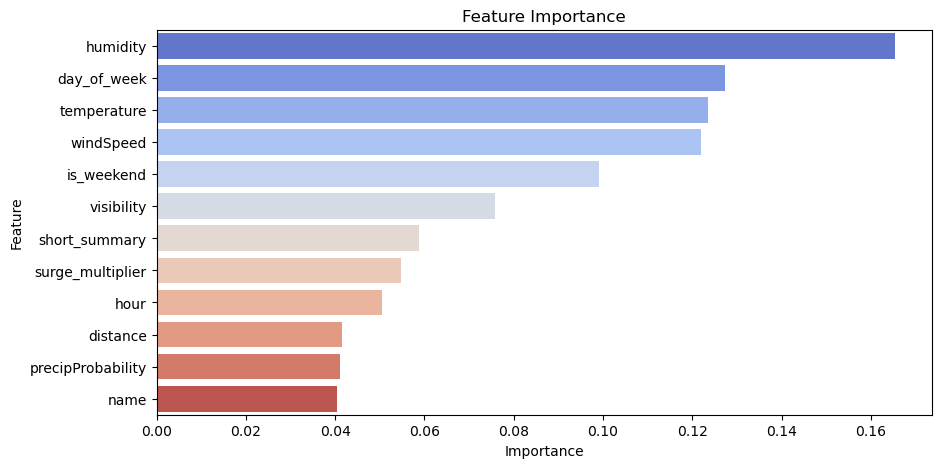

In [24]:
# Plot feature importance
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title("Feature Importance")
plt.show()

In [25]:
# Training accuracy
train_acc = model.score(X_train, y_train)

# Test accuracy
test_acc = model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Training Accuracy: 0.82
Test Accuracy: 0.82
